# Prueba Tecnica

    Para poder realizar cada uno de los numerales deberas buscar una relacion entre las 2 tablas para consolidarlas en una sola. Posterior a esto podras empezar con la solucion de los puntos

    Nota:  
    - El punto A y B los debes solucionar tanto en Sql como python. El punto C lo podras realizar con el lenguaje de tu preferencia
    - para obtener las bases de datos solo deberas ejecutar el bloque de codigo llamado 'DATA' en caso de un error puedes pedir ayuda

# Data

In [5]:
import pandas as pd
from os import path


'''
    Barrios: Información de los barrios (nombre y código)
    clientes: Información transaccional del cliente 
    
'''

df_barrios = pd.read_csv(path.join('Bases_insumo','barrios.csv'))
df_clientes = pd.read_csv(path.join('Bases_insumo','clientes.csv'))
df_dispositivos = pd.read_csv(path.join('Bases_insumo','dispositivos.csv'))
df_dispositivos.rename({'codigo':'cod_dispositivo'}, axis = 1, inplace= True)

df_join = df_barrios.merge(df_dispositivos, left_on ='codigo', 
                          right_on = 'id_barrio', how = 'inner').merge(df_clientes, on = 'cod_dispositivo', how = 'inner')


In [6]:
import pandasql as ps

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df_join

,codigo,nombre,tipo,cod_dispositivo,latitud,longitud,id_barrio,num_doc,tipo_doc,canal,num_trx,mnt_total_trx
0,737998257,La Campina,POS,12202503,3.479572,-76.525582,737998257,-2393994463924208659,1,POS,2,12202503.0
1,737998257,La Campina,POS,10521045,3.480517,-76.525275,737998257,-5675531380015678594,1,POS,1,5260522.5
2,737998257,La Campina,POS,10521045,3.480517,-76.525275,737998257,-5066077049535851626,1,POS,1,5260522.5
3,737998257,La Campina,POS,13238282,3.479491,-76.525818,737998257,-5791329717693361241,1,POS,1,6619141.0
4,737998257,La Campina,POS,12567517,3.480958,-76.525153,737998257,-397966594878551344,1,POS,1,6283758.5
...,...,...,...,...,...,...,...,...,...,...,...,...
94605,737998035,Ciudadela del Río,POS,11044369,3.425455,-76.464843,737998035,-3765831630548519698,1,POS,1,5522184.5
94606,737998035,Ciudadela del Río,POS,11044369,3.425455,-76.464843,737998035,2580778409722080163,1,POS,39,215365195.5
94607,737998035,Ciudadela del Río,POS,11044369,3.425455,-76.464843,737998035,-6052852033626412092,1,POS,1,5522184.5
94608,737998035,Ciudadela del Río,POS,11044369,3.425455,-76.464843,737998035,8994524193252232475,1,POS,2,11044369.0


# Punto a

* Generar el listado de clientes con transacciones en 5 o más barrios.

In [60]:
#Solución en sql

query = '''
    SELECT DISTINCT num_doc, sum(num_trx) as cant_transacciones, count(DISTINCT(id_barrio)) as cant_barrios
    FROM df_join
    GROUP BY num_doc
    HAVING cant_barrios > 5
    ORDER BY cant_barrios DESC;
'''

In [61]:
ps.sqldf(query, locals())

,num_doc,cant_transacciones,cant_barrios
0,-6943732889918790302,546,83
1,-6318594648243260200,307,77
2,3949050160426632961,393,75
3,956540030589798895,311,74
4,3785376175516210347,372,63
...,...,...,...
2995,-8970554719011755860,59,6
2996,-9016704368719499354,8,6
2997,-9044712566978972844,75,6
2998,-9099385232054024088,27,6


In [ ]:
conteo = df_join.groupby('num_doc')['nombre'].nunique()

docs_usuarios_5barrios = pd.DataFrame(conteo[conteo > 5])
#conteo.loc[conteo['nombre'] >= 5, ['num_doc']]
#f_count = df.groupby('cod_dispositivo')['nombre'].nunique().reset_index()

In [53]:
df_join.columns

Index(['codigo', 'nombre', 'tipo', 'cod_dispositivo', 'latitud', 'longitud',
       'id_barrio', 'num_doc', 'tipo_doc', 'canal', 'num_trx',
       'mnt_total_trx'],
      dtype='object')

In [47]:
ps.sqldf(query2, locals())

,cod_dispositivo,cant_transacciones,cant_barrios
0,747,3496,2
1,745,4128,2
2,2100027646,1,1
3,2100027645,7,1
4,2087227453,10,1
...,...,...,...
6009,75,105,1
6010,64,452,1
6011,62,487,1
6012,61,513,1


In [ ]:
#Solución en pandas



# Punto b

* ¿Cuáles son los 6 barrios donde la mayor cantidad de clientes únicos realizan transacciones en
dispositivos tipo PAC? La respuesta debe incluir la cantidad de clientes únicos asociados a estos
barrios.


In [56]:
query_3 = '''
    SELECT nombre, count(distinct(num_doc)) as clientes_unicos
    FROM df_join
    GROUP BY nombre
    ORDER BY clientes_unicos DESC
    LIMIT 6;
'''

In [57]:
ps.sqldf(query_3, locals())

,nombre,clientes_unicos
0,San Pedro,2516
1,San Vicente,1888
2,Urbanización San Juaquín,1756
3,Santa Mónica Residencial,1561
4,Chipichape,1555
5,Unidad Residencial Santiago de Cali,1547


In [84]:
cant_clientes_barrios = df_join.groupby('nombre')['num_doc'].nunique()
df_cant_clientes_barrios = pd.DataFrame(cant_clientes_barrios)
cond = df_cant_clientes_barrios.loc[:,'num_doc'] > 5
df_cant_clientes_barrios.loc[cond, :].sort_values(by = 'num_doc', ascending = False)

,num_doc
nombre,
San Pedro,2516
San Vicente,1888
Urbanización San Juaquín,1756
Santa Mónica Residencial,1561
Chipichape,1555
...,...
El Dorado,6
Unidad Residencial Bueno Madrid,6
Alto de los Chorros,6


# Punto c

Realizar analisis exploratorio de los datos y conclusiones. 

NOTA: Se debe agregar la documentación y trazabilidad del proceso realizado (Codigos y gráficas con las que se hicieron los análisis)

In [85]:
df_join.dtypes

codigo               int64
nombre              object
tipo                object
cod_dispositivo      int64
latitud            float64
longitud           float64
id_barrio            int64
num_doc              int64
tipo_doc             int64
canal               object
num_trx              int64
mnt_total_trx      float64
dtype: object

Analizando valores nulos.

In [87]:
(
    df_join
    .isnull()
    .any()
)

codigo             False
nombre             False
tipo               False
cod_dispositivo    False
latitud            False
longitud           False
id_barrio          False
num_doc            False
tipo_doc           False
canal              False
num_trx            False
mnt_total_trx      False
dtype: bool

In [88]:
df_join.describe()

,codigo,cod_dispositivo,latitud,longitud,id_barrio,num_doc,tipo_doc,num_trx,mnt_total_trx
count,9.461000e+04,9.461000e+04,94610.000000,94610.000000,9.461000e+04,9.461000e+04,94610.000000,94610.000000,9.461000e+04
mean,7.379996e+08,1.021508e+08,3.431533,-76.527226,7.379996e+08,5.405276e+16,1.029331,3.218793,1.642113e+08
std,5.786290e+03,3.501027e+08,0.038695,0.015552,5.786290e+03,5.354652e+18,0.175368,6.272047,1.357421e+09
min,7.379958e+08,6.000000e+01,3.332710,-76.561620,7.379958e+08,-9.218699e+18,1.000000,1.000000,3.000000e+01
25%,7.379982e+08,2.683000e+03,3.402170,-76.538723,7.379982e+08,-4.636108e+18,1.000000,1.000000,2.568500e+03
50%,7.379988e+08,6.605000e+03,3.437158,-76.528952,7.379988e+08,-5.789171e+16,1.000000,1.000000,2.043000e+04
75%,7.379994e+08,1.329378e+07,3.464452,-76.520886,7.379994e+08,4.578018e+18,1.000000,3.000000,7.370069e+06
max,7.380685e+08,2.100028e+09,3.499284,-76.462670,7.380685e+08,9.223358e+18,9.000000,315.000000,1.232095e+11


In [ ]:
(
    sns.histplot(
        data = df_join,
        x = 'num_trx',
        hue = 'nombre'
    )
)

<AxesSubplot:xlabel='canal', ylabel='num_trx'>

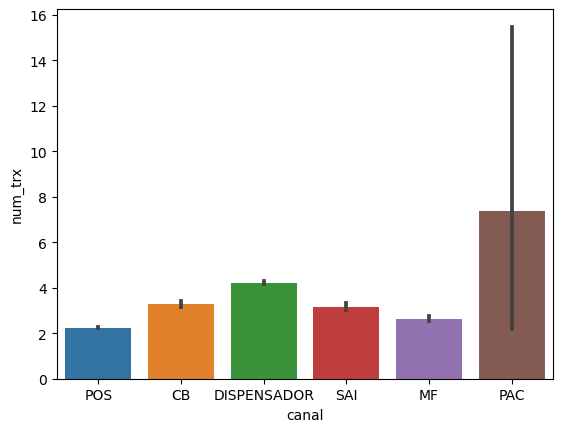

In [94]:
(
    sns.barplot(
        data = df_join,
        x = 'canal',
        y = 'num_trx'
    )
)